# CL Scenarios

In [ ]:
!pip install avalanche-lib==0.5.0 pytorchcv==0.0.67

In [1]:
from avalanche.benchmarks import SplitMNIST, PermutedMNIST, SplitCIFAR10, CORe50
from avalanche.training import Naive
from avalanche.benchmarks import benchmark_with_validation_stream
from avalanche.models import SlimResNet18
from avalanche.training import Naive
import torch

# Class-Incremental
- new classes at each experience
- no repetitions

In [2]:
benchmark = SplitMNIST(n_experiences=5)

for eid, exp in enumerate(benchmark.train_stream):
    tid = exp.task_label
    cls = exp.classes_in_this_experience
    print(f"(t={eid}) TASK={tid}, classes={cls}")

(t=0) TASK=0, classes=[3, 5]
(t=1) TASK=0, classes=[8, 7]
(t=2) TASK=0, classes=[1, 9]
(t=3) TASK=0, classes=[2, 6]
(t=4) TASK=0, classes=[0, 4]


# Domain-Incremental
- all the classes are available
- new instances at every step

In [3]:
benchmark = PermutedMNIST(n_experiences=5)

for eid, exp in enumerate(benchmark.train_stream):
    tid = exp.task_label
    cls = exp.classes_in_this_experience
    print(f"(t={eid}) TASK={tid}, classes={cls}")

(t=0) TASK=0, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
(t=1) TASK=0, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
(t=2) TASK=0, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
(t=3) TASK=0, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
(t=4) TASK=0, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


# Task-Free Continual Learning
- unknown task boundaries
- hard class-incremental drifts as before

if mini-batches are small, this is an online CL scenario

In [6]:
from avalanche.benchmarks import split_online_stream

benchmark = SplitMNIST(n_experiences=5)
ocl_stream = split_online_stream(benchmark.train_stream, experience_size=500)

for eid, exp in enumerate(ocl_stream):
    print(f"(t={eid}) classes={exp.dataset.targets.uniques}")

(t=0) classes={1, 9}
(t=1) classes={1, 9}
(t=2) classes={1, 9}
(t=3) classes={1, 9}
(t=4) classes={1, 9}
(t=5) classes={1, 9}
(t=6) classes={1, 9}
(t=7) classes={9, 1}
(t=8) classes={1, 9}
(t=9) classes={9, 1}
(t=10) classes={1, 9}
(t=11) classes={9, 1}
(t=12) classes={9, 1}
(t=13) classes={1, 9}
(t=14) classes={9, 1}
(t=15) classes={1, 9}
(t=16) classes={9, 1}
(t=17) classes={9, 1}
(t=18) classes={1, 9}
(t=19) classes={1, 9}
(t=20) classes={1, 9}
(t=21) classes={1, 9}
(t=22) classes={9, 1}
(t=23) classes={9, 1}
(t=24) classes={1, 9}
(t=25) classes={1, 9}
(t=26) classes={2, 4}
(t=27) classes={2, 4}
(t=28) classes={2, 4}
(t=29) classes={2, 4}
(t=30) classes={2, 4}
(t=31) classes={2, 4}
(t=32) classes={2, 4}
(t=33) classes={2, 4}
(t=34) classes={2, 4}
(t=35) classes={2, 4}
(t=36) classes={2, 4}
(t=37) classes={2, 4}
(t=38) classes={2, 4}
(t=39) classes={2, 4}
(t=40) classes={2, 4}
(t=41) classes={2, 4}
(t=42) classes={2, 4}
(t=43) classes={2, 4}
(t=44) classes={2, 4}
(t=45) classes={2, 4

# NiC
- new instances and classes
- a more realistic scenario

In [7]:
benchmark = CORe50()

for eid, exp in enumerate(benchmark.train_stream):
    tid = exp.task_label
    cls = exp.classes_in_this_experience
    print(f"(t={eid}) TASK={tid}, classes={cls}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5892103007/5892103007 [07:17<00:00, 13470094.93it/s]


Extracting core50_128x128.zip...
Extraction completed!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45418248/45418248 [00:02<00:00, 15786667.63it/s]


Extracting batches_filelists.zip...
Extraction completed!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13462303/13462303 [00:00<00:00, 15850516.21it/s]


Extracting batches_filelists_NICv2.zip...
Extraction completed!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5275590/5275590 [00:00<00:00, 15690362.77it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55523548/55523548 [00:03<00:00, 15828487.66it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26461948/26461948 [00:01<00:00, 15544247.31it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30444/30444 [00:00<00:00, 4876881.60it/s]


Loading labels...
Loading LUP...
Loading labels names...
(t=0) TASK=0, classes=[0, 35, 5, 40, 10, 45, 15, 20, 25, 30]
(t=1) TASK=0, classes=[20]
(t=2) TASK=0, classes=[20]
(t=3) TASK=0, classes=[20]
(t=4) TASK=0, classes=[15]
(t=5) TASK=0, classes=[15]
(t=6) TASK=0, classes=[0]
(t=7) TASK=0, classes=[25]
(t=8) TASK=0, classes=[5]
(t=9) TASK=0, classes=[40]
(t=10) TASK=0, classes=[20]
(t=11) TASK=0, classes=[15]
(t=12) TASK=0, classes=[10]
(t=13) TASK=0, classes=[5]
(t=14) TASK=0, classes=[40]
(t=15) TASK=0, classes=[10]
(t=16) TASK=0, classes=[20]
(t=17) TASK=0, classes=[8]
(t=18) TASK=0, classes=[30]
(t=19) TASK=0, classes=[30]
(t=20) TASK=0, classes=[45]
(t=21) TASK=0, classes=[8]
(t=22) TASK=0, classes=[0]
(t=23) TASK=0, classes=[40]
(t=24) TASK=0, classes=[25]
(t=25) TASK=0, classes=[45]
(t=26) TASK=0, classes=[5]
(t=27) TASK=0, classes=[8]
(t=28) TASK=0, classes=[21]
(t=29) TASK=0, classes=[21]
(t=30) TASK=0, classes=[0]
(t=31) TASK=0, classes=[30]
(t=32) TASK=0, classes=[8]
(t=33

# Evaluation

In OCL we used the prequential evaluation

code from the OCL intro notebook (NOTE: only shown for comparison against DCL loop):

```python
for x, y in iter_sklearn_dataset(iris, shuffle=True, seed=42):
    y_p = model.predict_one(x)   # First, Predict class-label for the CURRENT SAMPLE
    model.learn_one(x, y)        # Then, Train the model
```

now, we assume access to a parallel validation stream:

In [8]:
# a benchmark with task labels
benchmark = SplitCIFAR10(n_experiences=2)

device = 'cpu'  # do yourself a favor and use a gpu by setting device='cuda'
model = SlimResNet18(nclasses=100)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

strategy = Naive(  # naive finetuning
    model=model, 
    optimizer=optimizer, 
    criterion=criterion, 
    train_mb_size=32, train_epochs=1,
    eval_every=1
)

for exp in benchmark.train_stream:
    strategy.train(exp)  # First, train on the current exp
    strategy.eval(benchmark.test_stream)  # Then, evaluate on the ENTIRE VALIDATION STREAM

Files already downloaded and verified
Files already downloaded and verified
-- >> Start of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from train stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:51<00:00, 15.20it/s]
> Eval on experience 0 (Task 0) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task000/Exp000 = 4.5899
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp000 = 0.0000
-- >> End of eval phase << --
	Loss_Stream/eval_phase/train_stream/Task000 = 4.5899
	Top1_Acc_Stream/eval_phase/train_stream/Task000 = 0.0000
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:39<00:00,  4.91it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.0190
	Top1_Acc_Epoch/train_phase/t

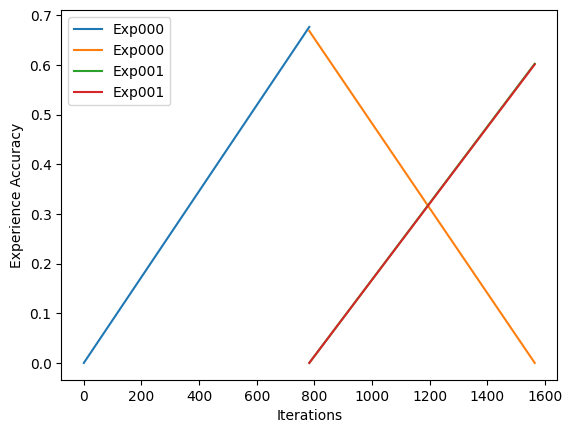

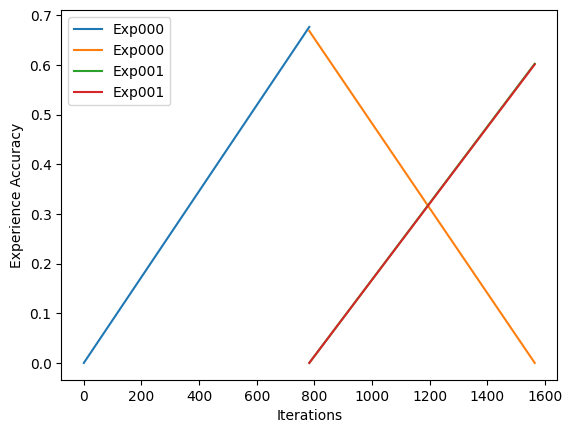

In [9]:
from avalanche.evaluation.plot_utils import learning_curves_plot
mall = strategy.evaluator.get_all_metrics()
learning_curves_plot(mall)

In [10]:
def get_accuracies(all_metrics):
    """Find accuracy metrics and return a dictionary with them
    
    return: dictionary where keys are the experience names (ExpXXX) and values are the learning curves (timestep, accuracy)
    """
    d = {}
    accs_keys = list(filter(lambda x: "Top1_Acc_Exp" in x, all_metrics.keys()))
    for ak in accs_keys:
        k = ak.split("/")[-1]
        x, y = all_metrics[ak]
        d[k] = x, y
    return d

get_accuracies(mall)

{'Exp000': ([782, 1564], [0.6682, 0.0]),
 'Exp001': ([782, 1564], [0.0, 0.60096])}

# Exercises
- increase the number of experiences to 5 for the SplitCIFAR10 experiment
- plot the accuracy for each experience
- use `get_accuracies` to compute the average stream accuracy over time (full stream and current+past data only)
- train a model on each experience separately and compare it with the Naive baseline
- you can try the evaluation for the other benchmarks (domain-incremental and online CL)
    - In online CL, use the `eval_every` argument to control the frequency of the evaluation. If you leave `eval_every=1`, you evaluate on the full stream after each minibatch, which is very expensive